<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predvidjanje vrednosti Bitcoina pomocu RNN**

**Korisceni atributi:** Open, High, Low, Close

**Filtrirani podaci:** od 28.03.2021.

## **Ucitavanje biblioteka**

In [94]:
# Ucitavanje biblioteka

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import callbacks
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
#%run preprocessing.ipynb

## **Ucitavanje skupa podataka i pretprocesiranje**

In [95]:
#data = preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [96]:
##### DELETE

file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'

# Ucitavanje skupa podataka
data = pd.read_csv(file_name)

# Dimenzije DataFrame-a
print('\n\nDimenzije skupa podataka pre sredjivanja:\n', data.shape)

# Ciscenje podataka od NaN vrednosti
data = data.dropna()

# Kreiranje datuma
data['Date'] = pd.to_datetime(data['Timestamp'], unit='s').dt.date # samo datum (bez vremena)

# Dimenzije DataFrame-a
print('\n\nDimenzije skupa podataka nakon sredjivanja:\n', data.shape)

data



Dimenzije skupa podataka pre sredjivanja:
 (4857377, 8)


Dimenzije skupa podataka nakon sredjivanja:
 (3613769, 9)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01
...,...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30


### **Podela skupa podataka**

In [97]:
###### DELETE

def data_split(data, test_size = 0):

  if test_size <= 0:
    print('Vrednost parametra test_size mora biti strogo veca od 0.\n')
    return
  else: # test_size > 0
    test_limit = len(data) - int(test_size * len(data))

  train = data[:test_limit]
  test = data[test_limit:]
  
  return train, test

In [98]:
# Podela inicijalnog skupa podataka na train i test skup

train, test = data_split(data, test_size = 0.2)


# Podela train skupa podataka na train i validacioni skup

train, validation = data_split(train, test_size = 0.2)

In [99]:
# Dimenzije train, validation i test skupa

train.shape, validation.shape, test.shape

((2312813, 9), (578203, 9), (722753, 9))

### **Vizualizacija validacionog skupa i train skupa**

In [100]:
##### DELETE

def plot_train_and_validation_data(train, validation):
  plt.title('Podaci za trening i validaciju')
  plt.xlabel('vreme')
  plt.ylabel('vrednost bitkoina')
  plt.plot(train, c = 'lime')
  plt.plot(validation, c = 'orchid')
  plt.show()

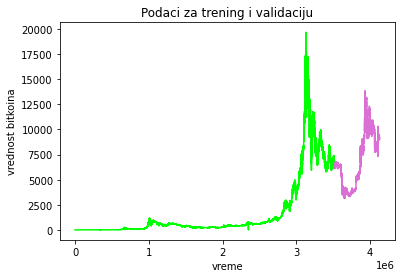

In [101]:
plot_train_and_validation_data(train = train['Close'], validation = validation['Close'])

### **Filtriranje trening, validacionog i test skupa**

In [102]:
# Izbacivanje nepotrebnih kolona (atributa) iz trening skupa

train_ = train.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
train_.head(), train_.shape

(      Open  High   Low  Close
 0     4.39  4.39  4.39   4.39
 478   4.39  4.39  4.39   4.39
 547   4.50  4.57  4.50   4.57
 548   4.58  4.58  4.58   4.58
 1224  4.58  4.58  4.58   4.58, (2312813, 4))

In [103]:
# Izbacivanje nepotrebnih kolona (atributa) iz validacionog skupa

validation_ = validation.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
validation_.head(), validation_.shape

(            Open     High      Low    Close
 3515412  6324.17  6330.54  6324.17  6330.54
 3515413  6328.17  6328.17  6321.47  6321.47
 3515414  6330.37  6331.24  6330.37  6331.24
 3515415  6334.31  6378.15  6334.31  6378.15
 3515416  6378.48  6405.00  6378.15  6387.36, (578203, 4))

In [104]:
# Izbacivanje nepotrebnih kolona (atributa) iz test skupa

test_ = test.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
test_.head(), test_.shape

(            Open     High      Low    Close
 4125128  9011.74  9014.99  9005.35  9014.99
 4125129  9007.76  9013.45  9007.76  9013.45
 4125130  9010.00  9010.00  9007.90  9007.90
 4125131  9010.00  9015.00  9006.25  9008.90
 4125132  9009.07  9015.00  9009.07  9015.00, (722753, 4))

In [105]:
# Dimenzije train skupa - pre i nakon izbacivanja atributa

train.shape, train_.shape

((2312813, 9), (2312813, 4))

In [106]:
#train_ = train_.values.tolist()
#validation_ = validation_.values.tolist()
#test_ = test_.values.tolist()

In [107]:
#len(train_)

**Odredjivanje ciljne promenljive na train skupu**

In [108]:
##### DELETE

def determine_x_and_y(dataset):
  X = []
  y = []

  for i in range(60, dataset.shape[0]):
    X.append(dataset[i-60:i])
    y.append(dataset[i,0])
  
  return X, y

In [109]:
#print(type(train_))
#scaler = MinMaxScaler(feature_range=(0, 1))
#train_ = scaler.fit_transform(train_)
#train_
#print(type(train_))

In [110]:
# Odredjivanje ciljne promenljive na train skupu

X_train, y_train = determine_x_and_y(dataset = train_.to_numpy())


# Odredjivanje ciljne promenljive na validacionom skupu

X_validation, y_validation = determine_x_and_y(dataset = validation_.to_numpy())


# Odredjivanje ciljne promenljive na test skupu

X_test, y_test = determine_x_and_y(dataset = test_.to_numpy())

In [1]:
X_train.shape

NameError: ignored

In [ ]:
df = pd.DataFrame(data = X_train)

**Skaliranje train skupa**

In [ ]:
# Skaliranje trening skupa

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_train


# Konverzija test skupa u np.array
# X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
# Konverzija u np.array

X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Dimenzije X_train

X_train.shape

(2238, 60, 4)

## **Kreiranje, kompilacija i treniranje mreze**

### **Kreiranje mreze**

In [ ]:
# Definicija funkcije koja kreira i vraca model mreze

def build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2]):

  net = Sequential()
  net.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (input_1, input_2)))
  net.add(Dropout(0.2))
  net.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.3))

  net.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.4))

  net.add(LSTM(units = 120, activation = 'relu'))
  net.add(Dropout(0.5))

  net.add(Dense(units =1))
  print(net.summary())

  return net


In [ ]:
# Kreiranje modela mreze

net = build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            11000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 120)              

### **Kompilacija i treniranje mreze**

In [ ]:
# Definicija funkcije za kompilaciju i treniranje mreze
# Treniranje je moguce vrsiti sa ili bez validacije

def compile_and_fit(optimizer, loss, metrics, X_train, y_train, epochs, batch_size, validation = 1, X_validation = None, y_validation = None, patience = 3):

  net.compile(optimizer = optimizer, loss = loss, metrics = metrics)

  callback = callbacks.EarlyStopping(monitor = 'loss', patience = patience)

  if validation == 0: # bez validacije
    history = net.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, callbacks=[callback])
  else: # sa validacijom
    history = net.fit(X_train, y_train, epochs = epochs, validation_data = (X_validation, y_validation), batch_size = batch_size, callbacks=[callback])

  return history, net


In [ ]:
# Kompilacija i treniranje mreze bez validacije

history_no_validation, net_no_validation = compile_and_fit(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train_ = X_train, y_train_ = y_train, epochs = 20, batch_size = 50, validation = 0, patience = 3)


# Kompilacija i treniranje mreze sa validacijom

history_validation, net_validation = compile_and_fit(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train_ = X_train, y_train_ = y_train, epochs = 20, batch_size = 50, validation = 1, X_validation = X_validation, y_validation = y_validation, patience = 3)


Epoch 1/20
41/41 [==============================] - 13s 220ms/step - loss: 0.0602 - mse: 0.0602 - mae: 0.1858 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0671
Epoch 2/20
41/41 [==============================] - 8s 204ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0896 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0261
Epoch 3/20
41/41 [==============================] - 8s 202ms/step - loss: 0.0108 - mse: 0.0108 - mae: 0.0784 - val_loss: 0.0134 - val_mse: 0.0134 - val_mae: 0.1127
Epoch 4/20
41/41 [==============================] - 8s 202ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0710 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.1011
Epoch 5/20
41/41 [==============================] - 8s 204ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0672 - val_loss: 0.0208 - val_mse: 0.0208 - val_mae: 0.1419
Epoch 6/20
41/41 [==============================] - 8s 202ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0664 - val_loss: 0.0258 - val_mse: 0.0258 - val_mae: 0.1586
Epoch 7/20
41/4

## **Predvidjanje**

In [ ]:
# Predvidjanje za mrezu treniranu bez i sa validacijom

# Bez validacije
y_predicted_no_validation = net_no_validation.predict(X_test)
print('Predvidjene vrednosti - bez validacije:\n', y_predicted_no_validation)

# Sa validacijom
y_predicted_validation = net_validation.predict(X_test)
print('\nPredvidjene vrednosti - sa validacijom:\n', y_predicted_validation)

Predvidjene vrednosti - bez validacije:
 [[0.75165933]
 [0.7511229 ]
 [0.7502168 ]
 [0.74906045]
 [0.74779767]
 [0.74649435]
 [0.7451803 ]
 [0.7438466 ]
 [0.7424785 ]
 [0.7411187 ]
 [0.7398066 ]
 [0.7385264 ]
 [0.73724407]
 [0.73594105]
 [0.73457474]
 [0.7330907 ]
 [0.731538  ]
 [0.7300557 ]
 [0.7287609 ]
 [0.72772413]
 [0.72699255]
 [0.72654176]
 [0.72630775]
 [0.72618765]
 [0.7260579 ]
 [0.7257975 ]
 [0.72528523]
 [0.7243476 ]
 [0.7229243 ]
 [0.721063  ]
 [0.71888363]
 [0.7164924 ]
 [0.7140276 ]
 [0.7116976 ]
 [0.7096926 ]
 [0.7080289 ]
 [0.7067484 ]
 [0.7059063 ]
 [0.7054347 ]
 [0.7051353 ]
 [0.7047973 ]
 [0.7042917 ]
 [0.7036444 ]
 [0.7029725 ]
 [0.70242244]
 [0.7021992 ]
 [0.7025116 ]
 [0.70339465]
 [0.7046826 ]
 [0.7062165 ]
 [0.707914  ]
 [0.70969415]
 [0.71145654]
 [0.71314764]
 [0.71479434]
 [0.71636575]
 [0.7177921 ]
 [0.71896404]
 [0.7198368 ]
 [0.72037816]
 [0.720537  ]
 [0.720336  ]
 [0.7199187 ]
 [0.7194597 ]
 [0.71913826]
 [0.7190475 ]
 [0.7192003 ]
 [0.7195838 ]
 [0.720

## **Vizualizacija rezultata predvidjanja i metrika**

In [ ]:
# Vizuelni prikaz rezultata modela mreze

def plot_real_vs_predicted_data(test_set, predicted_set):

  fig, ax = plt.subplots(1, figsize=(16, 9))
  ax.plot(test_set, label='Stvarna vrednost BTC', linewidth=2)
  ax.plot(predicted_set, label='Predvidjena vrednost BTC', linewidth=2)
  ax.set_xlabel('Redni broj instance', fontsize=14)
  ax.set_ylabel('Cena [USD]', fontsize=14)
  ax.set_title(label = 'Vizuelni prikaz stvarne i predvidjene vrednosti BTC', fontsize=18)
  ax.legend(loc='best', fontsize=18)

  # test = test.reset_index()
  # x = test.index


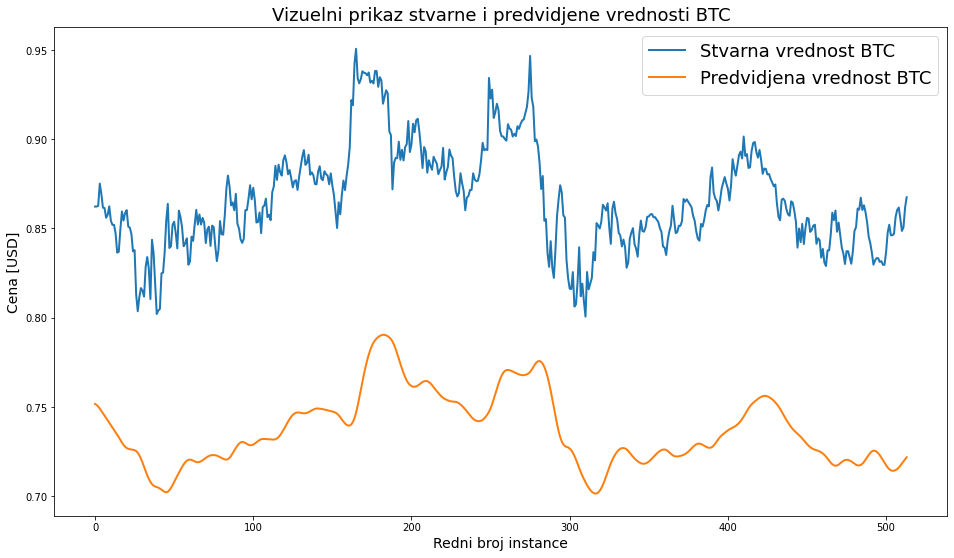

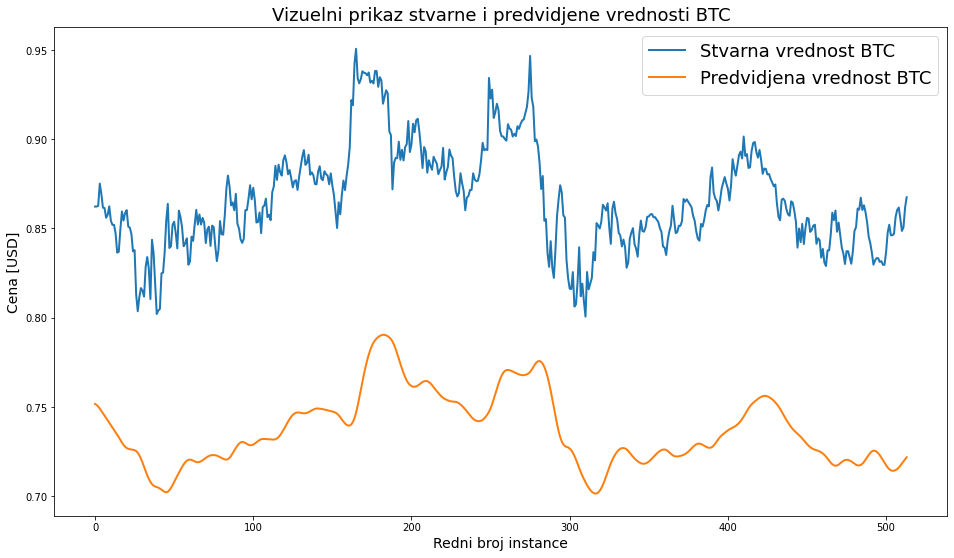

In [ ]:
# Plotovanje stvarne i predvidjene vrednosti

# Bez validacije
plot_real_vs_predicted_data(test_set = y_test, predicted_set = y_predicted_no_validation)

# Sa validacijom
plot_real_vs_predicted_data(test_set = y_test, predicted_set = y_predicted_validation)

In [ ]:
# Vizuelni prikaz gubitka i tacnosti tokom treniranja mreze

# Ukoliko je validacija nije koriscena tokom treniranja mreze,
# onda parametar is_validation_used treba biti 0, a inace 1

def plot_loss_and_mse(history_, is_validation_used):

  epochs = range(len(history_.history['loss'])) # broj epoha

  plt.title('Vizuelni prikaz gubitka (loss) i MSE (mse) mreze')


  # Gubitak

  plt.subplot(211)
  
  plt.plot(epochs, history_.history['loss'], label='Gubitak (loss) tokom treniranja')

  if is_validation_used == 1:
    plt.plot(epochs, history_.history['val_loss'], label='Gubitak (val_loss) tokom validacije')
  
  plt.legend()


  # Tacnost

  plt.subplot(212)

  plt.plot(epochs, history_.history['mse'], label='MSE tokom treniranja')
  
  if is_validation_used == 1:
    plt.plot(epochs, history_.history['val_mse'], label='MSE (val_mse) tokom validacije')
  
  plt.legend()

  plt.show()


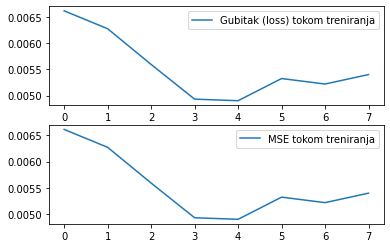

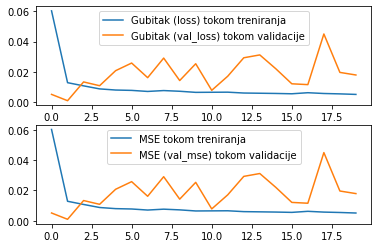

In [ ]:
# Plotovanje gubitka i tacnosti mreze tokom treniranja

plot_loss_and_mse(history_ = history_no_validation, is_validation_used = 0)

plot_loss_and_mse(history_ = history_validation, is_validation_used = 1)

In [ ]:
# Vizuelni prikaz MAE

def plot_mae(history_):

  epochs = range(len(history_.history['mae'])) # broj epoha
  plt.title('Vizuelni prikaz MAE (mae')
  plt.xlabel('broj epohe')
  plt.ylabel('MAE')
  
  plt.plot(epochs, history_.history['mae'], label='MAE (mae) tokom treniranja')

  if 'val_mae' in history_.history:
    plt.plot(epochs, history_.history['val_mae'], label='MAE (val_mae) tokom treniranja sa validacijom')

  plt.legend(loc = 'best')

  plt.show()


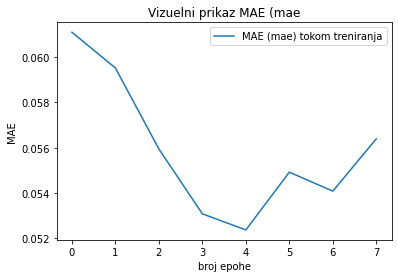

In [ ]:
# MAE

plot_mae(history_no_validation)

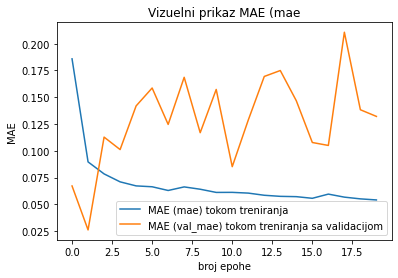

In [ ]:
# MAE - sa validacijom

plot_mae(history_validation)

In [ ]:
# Loss, MSE, MAE nad skupom za testiranje

# (za model koji pri treniranju koristi validaciju
# i za model koji pri treniranju ne koristi validaciju)

test_metrics_no_val = net_no_validation.evaluate(X_test, y_test)
test_metrics_val = net_validation.evaluate(X_test, y_test)

print('\nMetrike prilikom testiranja - model treniran bez validacije\n')
print(net_no_validation.metrics_names[0], test_metrics_no_val[0])
print(net_no_validation.metrics_names[1], test_metrics_no_val[1])
print(net_no_validation.metrics_names[2], test_metrics_no_val[2])

print('\n\nMetrike prilikom testiranja - model treniran sa validacijom\n')
print(net_validation.metrics_names[0], test_metrics_val[0])
print(net_validation.metrics_names[1], test_metrics_val[1])
print(net_validation.metrics_names[2], test_metrics_val[2])

17/17 [==============================] - 1s 38ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.1289

Metrike prilikom testiranja - model treniran bez validacije

loss 0.01694270223379135
mse 0.01694270223379135
mae 0.12892593443393707


Metrike prilikom testiranja - model treniran sa validacijom

loss 0.01694270223379135
mse 0.01694270223379135
mae 0.12892593443393707


In [ ]:
# R2 skor nad skupom za testiranje
from sklearn import metrics

r2 = metrics.r2_score(y_predicted_no_validation, y_test)
r2_val = metrics.r2_score(y_predicted_validation, y_test)

print('R2 skor prilikom testiranja - model treniran bez validacije', r2)
print('R2 skor prilikom testiranja - model treniran sa validacijom', r2_val)

R2 skor prilikom testiranja - model treniran bez validacije -40.31017036466142
R2 skor prilikom testiranja - model treniran sa validacijom -40.31017036466142
